In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('../data/wb_equator_temps_gdp.pq')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5313 entries, 0 to 5312
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country_Name            5313 non-null   object 
 1   Country_Code            5313 non-null   object 
 2   Year                    5313 non-null   float64
 3   Cereal_Yield            5313 non-null   float64
 4   Arable_Land_Percent     5313 non-null   float64
 5   Value_Added_AFF         5313 non-null   float64
 6   Arable_Land_Person      5313 non-null   float64
 7   Freshwater_Withdrawl    5313 non-null   float64
 8   Fertilizer              5313 non-null   float64
 9   Education_Expenditure   5313 non-null   float64
 10  Natural_Resource_Rents  5313 non-null   float64
 11  Distance_Equator        5313 non-null   float64
 12  avg_temp                5313 non-null   float64
 13  GDP per capita          5313 non-null   float64
dtypes: float64(12), object(2)
memory usage: 

In [4]:
df.head()

Country_Name Country_Code    Year  Cereal_Yield  Arable_Land_Percent  \
0       Norway          NOR  1971.0      8.079401             1.163547   
1  Netherlands          NLD  1971.0      8.371358             3.170024   
2    Nicaragua          NIC  1971.0      6.988136             2.266147   
3      Namibia          NAM  1971.0      5.842094             0.583301   
4        Niger          NER  1971.0      6.053970             2.288729   

   Value_Added_AFF  Arable_Land_Person  Freshwater_Withdrawl  Fertilizer  \
0         1.804178            0.187304              1.429050    5.563376   
1         1.758224            0.056718              1.019467    6.661533   
2         3.306797            0.344867              1.213858    3.261124   
3         3.138460            0.609293              1.185488    1.919471   
4         4.196612            1.206025              0.253070    0.022200   

   Education_Expenditure  Natural_Resource_Rents  Distance_Equator  avg_temp  \
0               1.796640                0.334428          4.143135      3.24   
1               1.991730                0.093283          3.979682      9.51   
2               1.250483                1.206264          2.639057     26.21   
3               1.506671                2.041281          3.135494     19.64   
4               0.718947                1.028939          2.833213     29.34   

   GDP per capita  
0         16692.0  
1         19636.0  
2          4533.0  
3          6258.0  
4          1382.0

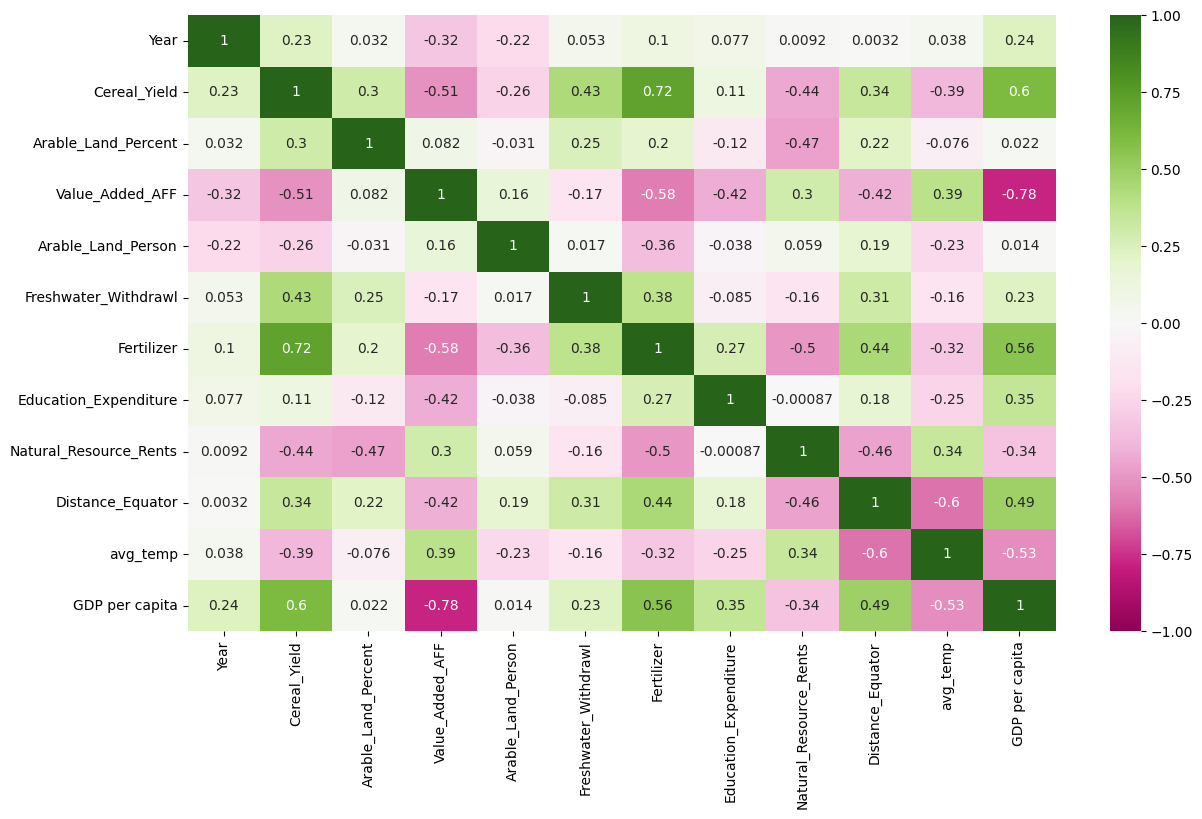

In [5]:
fig, ax = plt.subplots(figsize = (14, 8))
sns.heatmap(df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'PiYG');

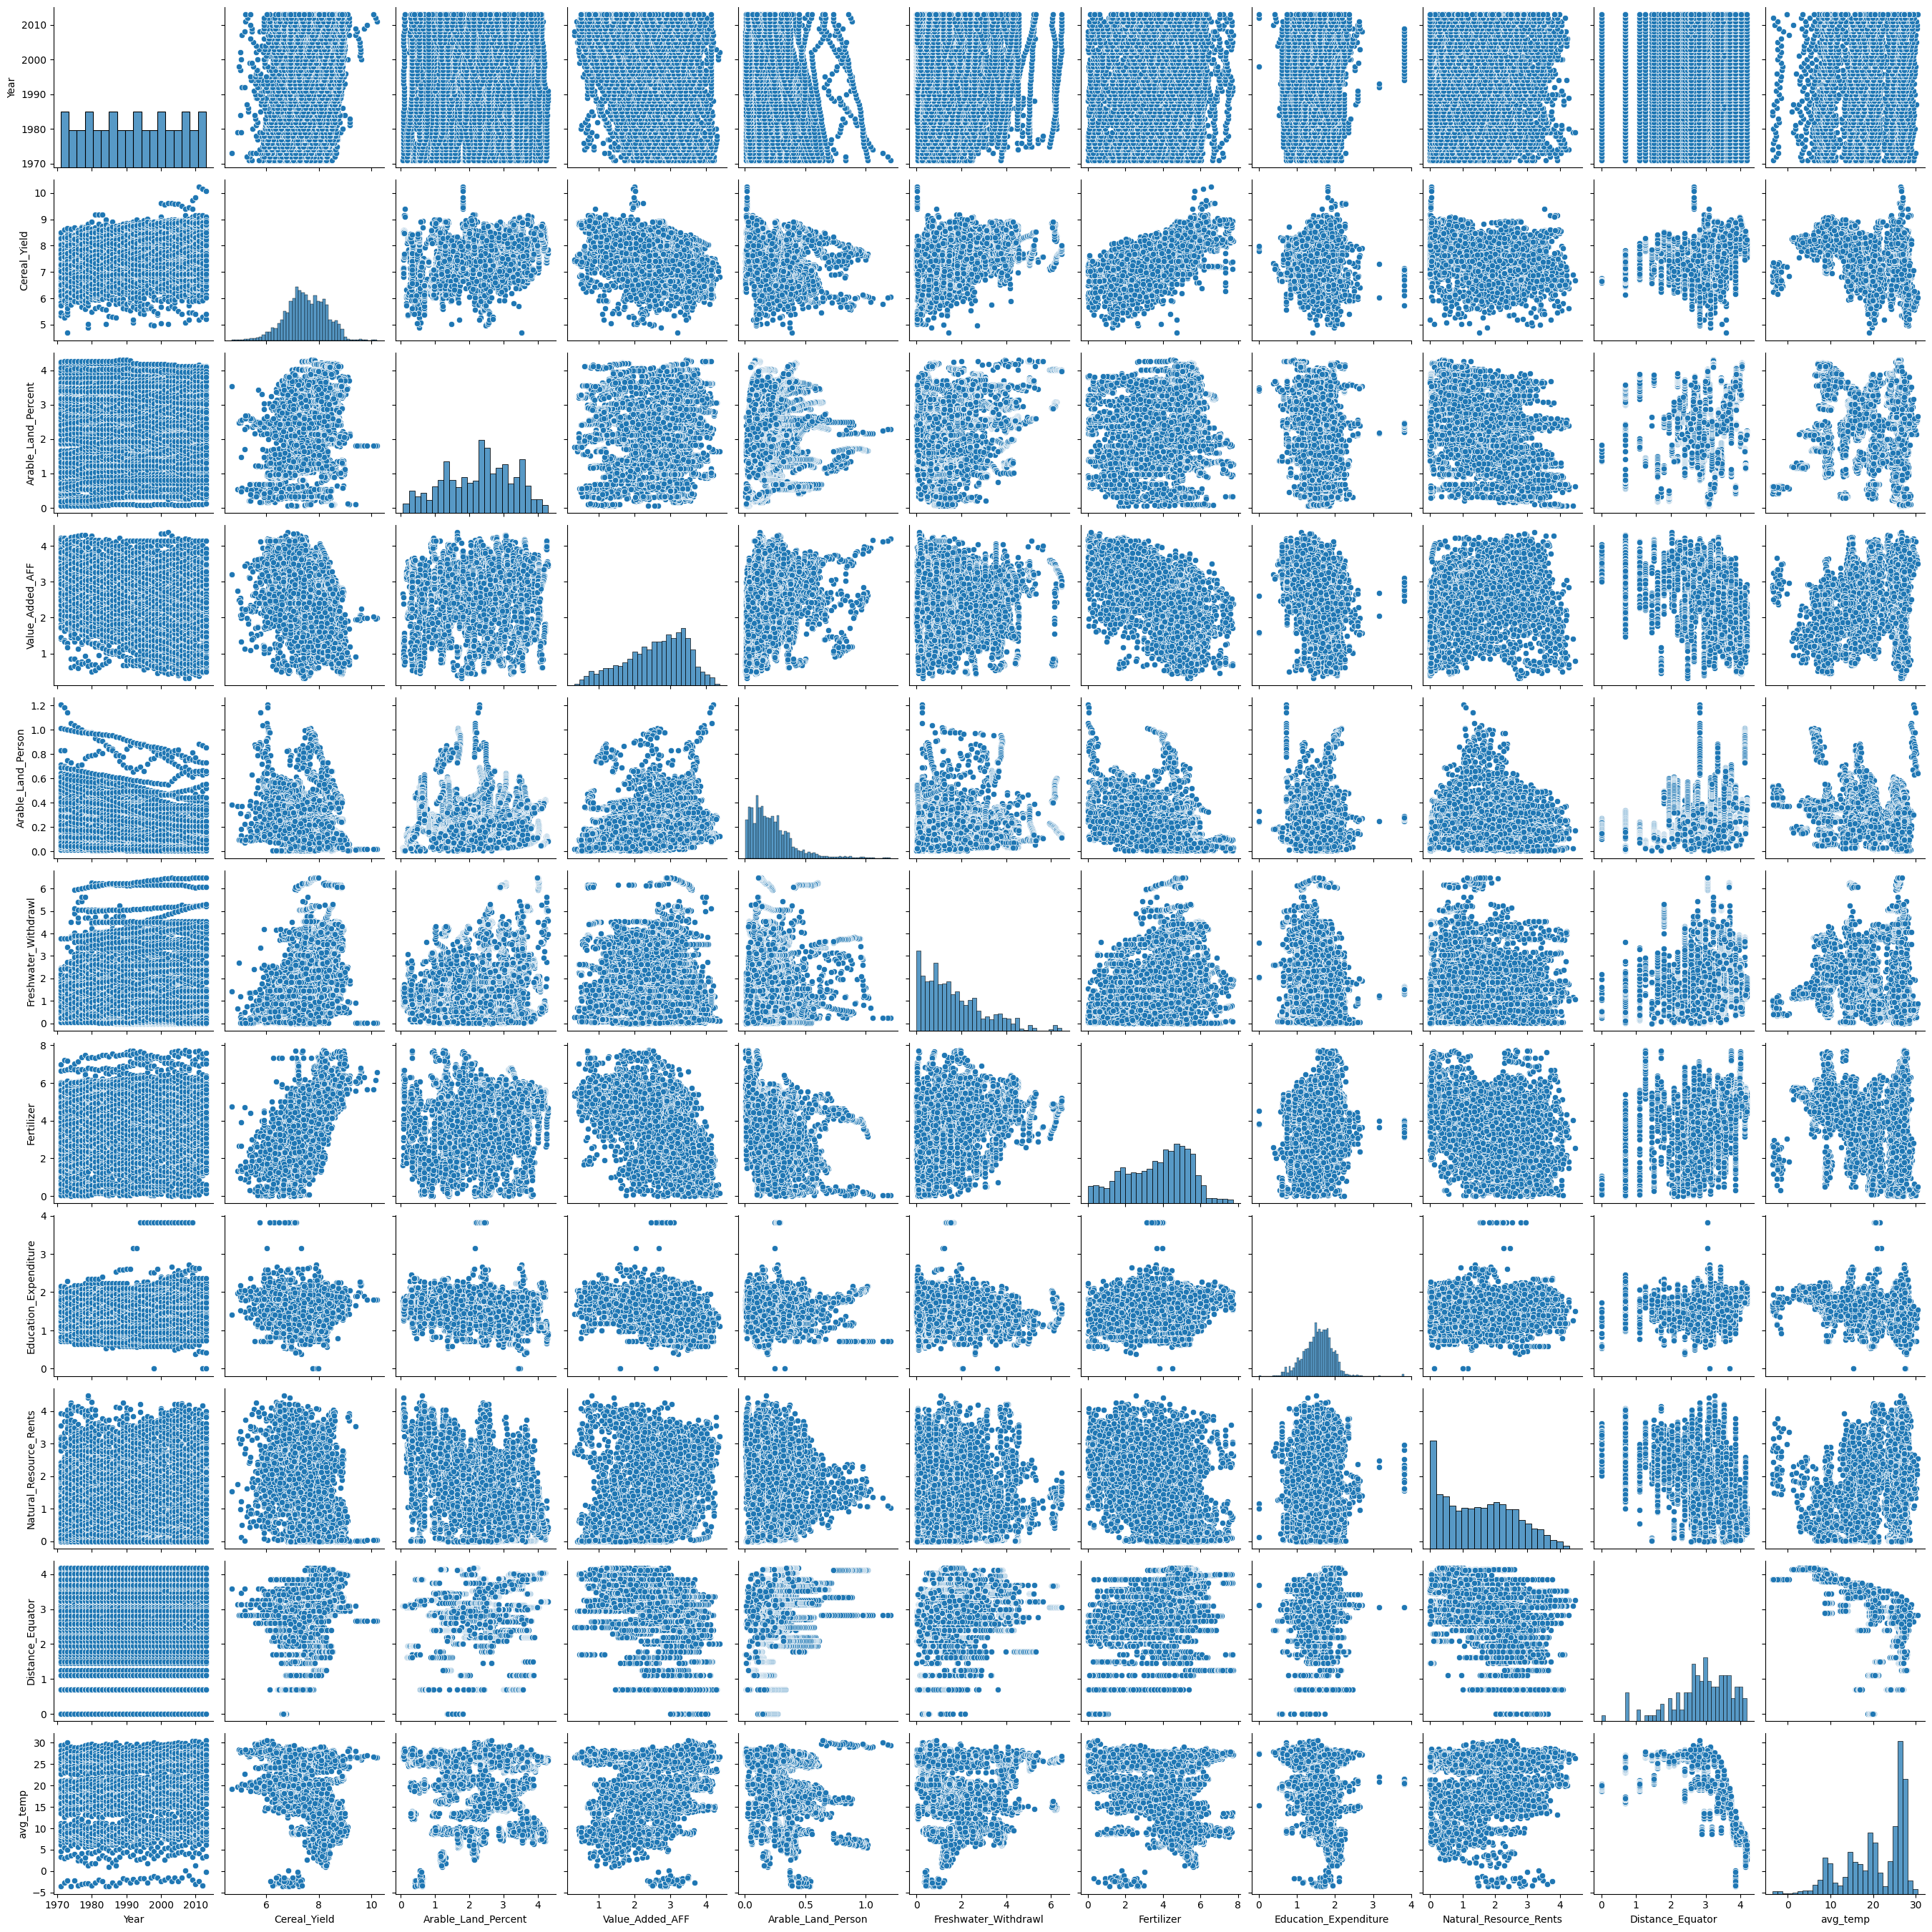

In [6]:
sns.pairplot(df);

##### As used in the first model, fertilizer, machinery and water withdrawls have the strongest positive correlations. 
##### Now lets add in some of the strongest negative variables: ag, forest & fish GDP, employment in ag and total natural resources GDP

# Linear Regression

In [6]:
X = df.drop(columns = ['Country_Name', 'Country_Code', 'Cereal_Yield'])
y = df['Cereal_Yield']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 56)

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4250, 11) (1063, 11) (4250,) (1063,)


In [9]:
scores = []

for degree in np.arange(1, 6):
    pipe = Pipeline([('polynomial', PolynomialFeatures(degree = degree)), ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    mae_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    mae_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    
    scores.append([degree, mae_train, mae_test])

In [10]:
poly_line_reg_scores = pd.DataFrame(scores, columns = ['Degree', 'MAPE Train', 'MAPE Test'])

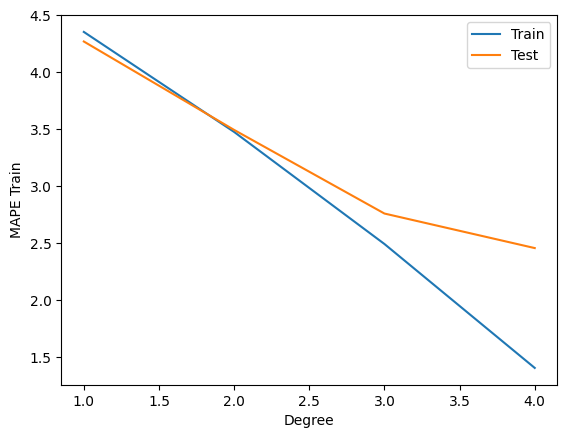

In [11]:
sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Train', label = 'Train')
sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Test', label = 'Test');

In [11]:
pipe = Pipeline([('polynomial', PolynomialFeatures(degree = 3)), ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
pipe.fit(X_train, y_train)

print('train_score', round(pipe.score(X_train, y_train), 2))
print('test_score', round(pipe.score(X_test, y_test), 2))

y_pred_test = np.exp(pipe.predict(X_test))
y_pred_train = np.exp(pipe.predict(X_train))

mape_test = mean_absolute_percentage_error(np.exp(y_test), y_pred_test) * 100
mape_train = mean_absolute_percentage_error(np.exp(y_train), y_pred_train) * 100
print('mape_test:', round(mape_test, 2), '\nmape_train:', round(mape_train, 2))

train_score 0.89
test_score 0.86
mape_test: 21.54 
mape_train: 19.0


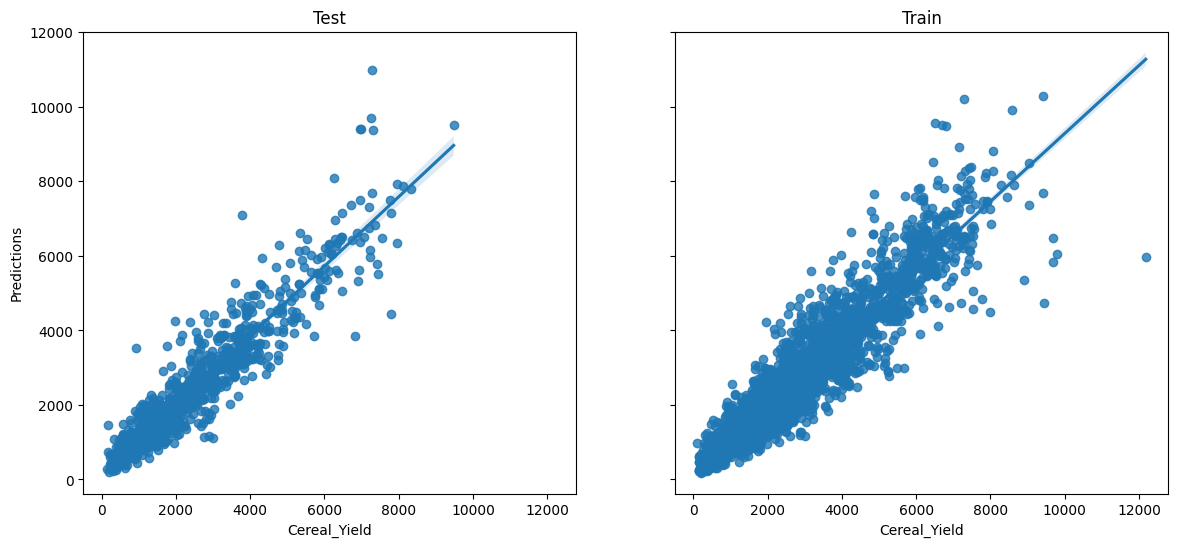

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6), sharex = True, sharey = True)
sns.regplot(x = np.exp(y_test), y = y_pred_test, ax = ax[0])
ax[0].set_ylabel("Predictions")
ax[0].set_title("Test")

sns.regplot(x = np.exp(y_train), y = y_pred_train, ax = ax[1])
ax[1].set_title("Train");

In [13]:
poly_3_coefs = pd.DataFrame({'Features': pipe['polynomial'].get_feature_names_out(X_train.columns), 'coefs': pipe['lin_reg'].coef_}).sort_values(by = 'coefs')

In [14]:
poly_3_coefs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 16 to 12
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Features  364 non-null    object 
 1   coefs     364 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.5+ KB


In [15]:
poly_3_coefs.head()

Features        coefs
16  Year Freshwater_Withdrawl -2980.033199
78                     Year^3 -2097.628290
1                        Year -2076.275112
22        Year GDP per capita -1904.296161
14       Year Value_Added_AFF -1379.332983

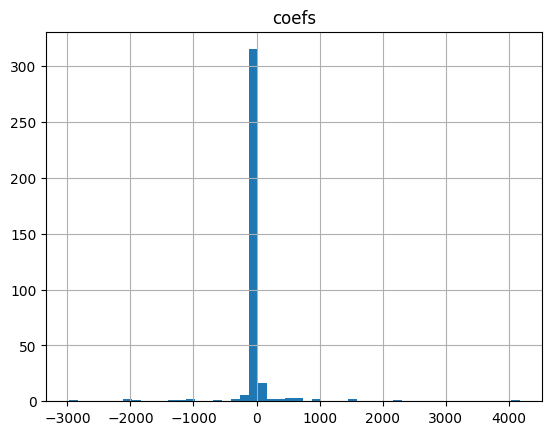

In [20]:
poly_3_coefs.hist(bins = 50);

In [19]:
poly_3_coefs_filtered = poly_3_coefs[(poly_3_coefs['coefs'] > 200) | (poly_3_coefs['coefs'] < -200)]

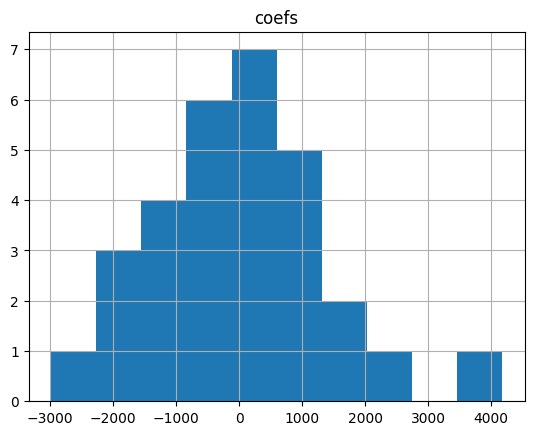

In [21]:
poly_3_coefs_filtered.hist();

In [24]:
poly_3_coefs_filtered.shape

(30, 2)

### So we could try using the selectkbest with a values of 20, 30, 40, 50 to find a good comprimise on interpretibility and accuracy

In [31]:
pipe = Pipeline([('polynomial', PolynomialFeatures(degree = 3)), ('scaler', StandardScaler()), ('selectk', SelectKBest()), ('lin_reg', LinearRegression())])

pipe_param = {
    "selectk__k": [20, 30, 40, 50, 60, 70],
    "polynomial__degree": [2, 3]
}

gs_pipe = GridSearchCV(pipe,
                        pipe_param,
                        cv = 5,
                        scoring = 'neg_mean_absolute_percentage_error',
                        verbose = 1,
                        n_jobs = -1,
                        error_score = 0.0)



In [32]:
gs_pipe.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

GridSearchCV(cv=5, error_score=0.0,
             estimator=Pipeline(steps=[('polynomial',
                                        PolynomialFeatures(degree=3)),
                                       ('scaler', StandardScaler()),
                                       ('selectk', SelectKBest()),
                                       ('lin_reg', LinearRegression())]),
             n_jobs=-1,
             param_grid={'polynomial__degree': [2, 3],
                         'selectk__k': [20, 30, 40, 50, 60, 70]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [33]:
print('best_estimator_:', gs_pipe.best_estimator_)
print('best_score_:', gs_pipe.best_score_)
print('best_params_:', gs_pipe.best_params_)

best_estimator_: Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('scaler', StandardScaler()), ('selectk', SelectKBest(k=70)),
                ('lin_reg', LinearRegression())])
best_score_: -0.036529873531941474
best_params_: {'polynomial__degree': 2, 'selectk__k': 70}


In [34]:
print('train_score', round(gs_pipe.score(X_train, y_train), 2))
print('test_score', round(gs_pipe.score(X_test, y_test), 2))

y_pred_test = np.exp(gs_pipe.predict(X_test))
y_pred_train = np.exp(gs_pipe.predict(X_train))

mape_test = mean_absolute_percentage_error(np.exp(y_test), y_pred_test) * 100
mape_train = mean_absolute_percentage_error(np.exp(y_train), y_pred_train) * 100
print('mape_test:', round(mape_test, 2), '\nmape_train:', round(mape_train, 2))

train_score -0.04
test_score -0.04
mape_test: 28.4 
mape_train: 28.07


In [62]:
results = []
for k in np.arange(10, 160, 2):
    pipe = Pipeline([('polynomial', PolynomialFeatures(degree = 3)), ('scaler', StandardScaler()), ('selectk', SelectKBest(k = k)), ('lin_reg', LinearRegression())])
    
    pipe.fit(X_train, y_train)

    y_pred_test = np.exp(pipe.predict(X_test))
    y_pred_train = np.exp(pipe.predict(X_train))

    mape_test = mean_absolute_percentage_error(np.exp(y_test), y_pred_test) * 100
    mape_train = mean_absolute_percentage_error(np.exp(y_train), y_pred_train) * 100
    
    results.append([k, mape_train, mape_test])
    
results = pd.DataFrame(results, columns = ['k_Best', 'MAPE Train', 'MAPE Test'])

/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

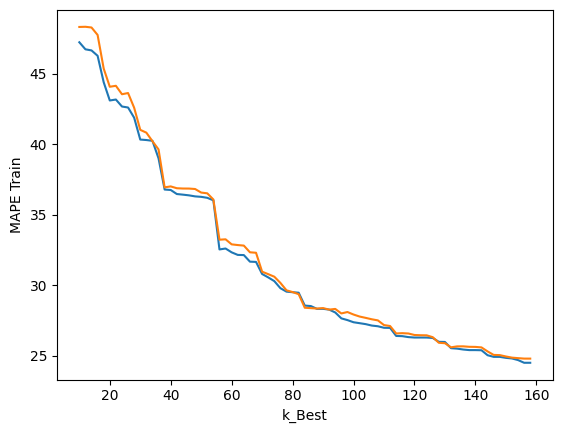

In [63]:
sns.lineplot(data = results, x = 'k_Best', y = 'MAPE Train')
sns.lineplot(data = results, x = 'k_Best', y = 'MAPE Test');

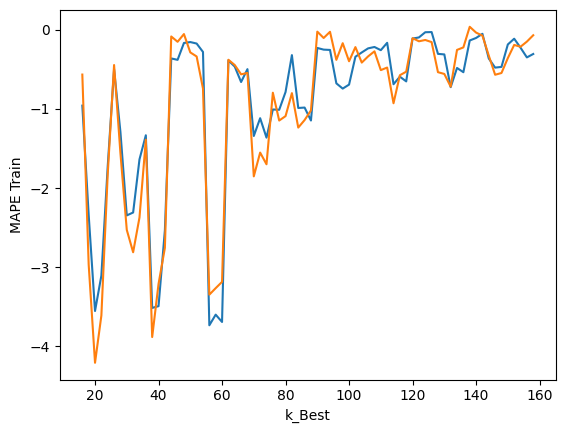

In [66]:
sns.lineplot(x = results['k_Best'], y = (results['MAPE Train'] - results['MAPE Train'].shift(3)))
sns.lineplot(x = results['k_Best'], y = (results['MAPE Test'] - results['MAPE Test'].shift(3)));

### We see a clear improvement here with the addition of the temp and distance from equator variables
### We can see that the vast majority of features do not offer any anything to the model so let's set a filter and drop a large number of these with low coefficients, then also run a regularilisation
### Also try this with a random forest regression and pull out important features

In [65]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
pipe = Pipeline(steps = 
                [('polynomial', PolynomialFeatures(degree = 2)), 
                 ('scaler', StandardScaler()), 
                 ('selectk', SelectKBest()), 
                 ('rf_reg', RandomForestRegressor())])

pipe_param = {
    "selectk__k": [20, 30, 40, 50, 60, 70],
    'rf_reg__max_depth': [2, 4, 8]
}

gs_pipe = GridSearchCV(pipe,
                        pipe_param,
                        cv = 5,
                        scoring = 'neg_mean_absolute_percentage_error',
                        verbose = 1,
                        n_jobs = -1,
                        error_score = 0.0)

In [68]:
gs_pipe.fit(X_train, y_train)

y_pred_test = np.exp(gs_pipe.predict(X_test))
y_pred_train = np.exp(gs_pipe.predict(X_train))

mape_test = mean_absolute_percentage_error(np.exp(y_test), y_pred_test) * 100
mape_train = mean_absolute_percentage_error(np.exp(y_train), y_pred_train) * 100

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

In [72]:
print('MAPE Train:', mape_train, 'MAPE Test:', mape_test)

MAPE Train: 13.469236246555063 MAPE Test: 19.445413920452488


In [69]:
gs_pipe.best_estimator_

Pipeline(steps=[('polynomial', PolynomialFeatures()),
                ('scaler', StandardScaler()), ('selectk', SelectKBest(k=70)),
                ('rf_reg', RandomForestRegressor(max_depth=8))])

In [80]:
results_rf = []
for k in np.arange(8, 88, 10):
    pipe = Pipeline(steps = 
                [('polynomial', PolynomialFeatures(degree = 2)), 
                 ('scaler', StandardScaler()), 
                 ('selectk', SelectKBest(k = k)), 
                 ('rf_reg', RandomForestRegressor(max_depth = 8))])
    
    pipe.fit(X_train, y_train)

    y_pred_test = np.exp(pipe.predict(X_test))
    y_pred_train = np.exp(pipe.predict(X_train))

    mape_test = mean_absolute_percentage_error(np.exp(y_test), y_pred_test) * 100
    mape_train = mean_absolute_percentage_error(np.exp(y_train), y_pred_train) * 100
    
    results.append([k, mape_train, mape_test])
    
results_rf = pd.DataFrame(results, columns = ['k_Best', 'MAPE Train', 'MAPE Test'])

/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/home/sean/.local/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_featu

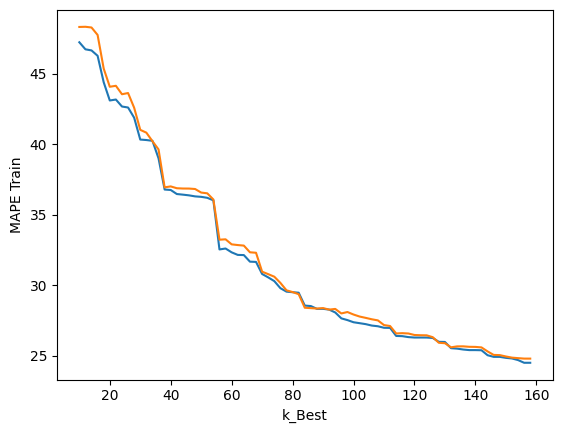

In [81]:
sns.lineplot(data = results_rf, x = 'k_Best', y = 'MAPE Train')
sns.lineplot(data = results_rf, x = 'k_Best', y = 'MAPE Test');